# Desafío - Naive Bayes

__Integrantes:__ 

- Yerko Carreño
- Javier Pilasi 
- Daniel Flores
- Francisco Fernandez
- Máximo Oliva
- Rocío Ehijo
- Cristián Contreras


# Descripción

- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a patir de la letra de una canción.
- Existen 4 géneros que se registran en la base de datos, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

## Preparación del Ambiente de Trabajo

- Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples
archivos dentro de la carpeta dump .
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump
utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere
un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [73]:
# Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

import missingno as msngo
import warnings

from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

In [2]:
# Leer archivos en ruta dump

files = glob.glob("dump/*", recursive=True)

li = []

for filename in files:
    df_file = pd.read_csv(filename, index_col=0)
    li.append(df_file)

df = pd.concat(li, ignore_index=True)
df.columns = ["artista", "genero", "cancion", "letra"]
display(df.head())

,artista,genero,cancion,letra
0,Vital Remains,metal,Human Sacrifice,Taken to death from sacrifice \n Carving out y...
1,Vital Remains,metal,Ressurrected,Doomed to an after life of pain \n Seeing your...
2,Vital Remains,metal,Fallen Angels,Fallen angels souls of hate \n Fallen angels c...
3,Vital Remains,metal,Excruciating Pain,Feel the torment of brutal bestial torture \n ...
4,Vital Remains,metal,Nocturnal Blasphemy,Blasphemy \n Awakened by nocturnal cries \n Su...


## Descripción de los datos

- Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    - La cantidad de canciones registradas por cada artista, ordenado de mayor a menor.
    - La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
- Comente sobre las principales tendencias.

Text(0.5, 1.0, 'Número de canciones registradas por género')

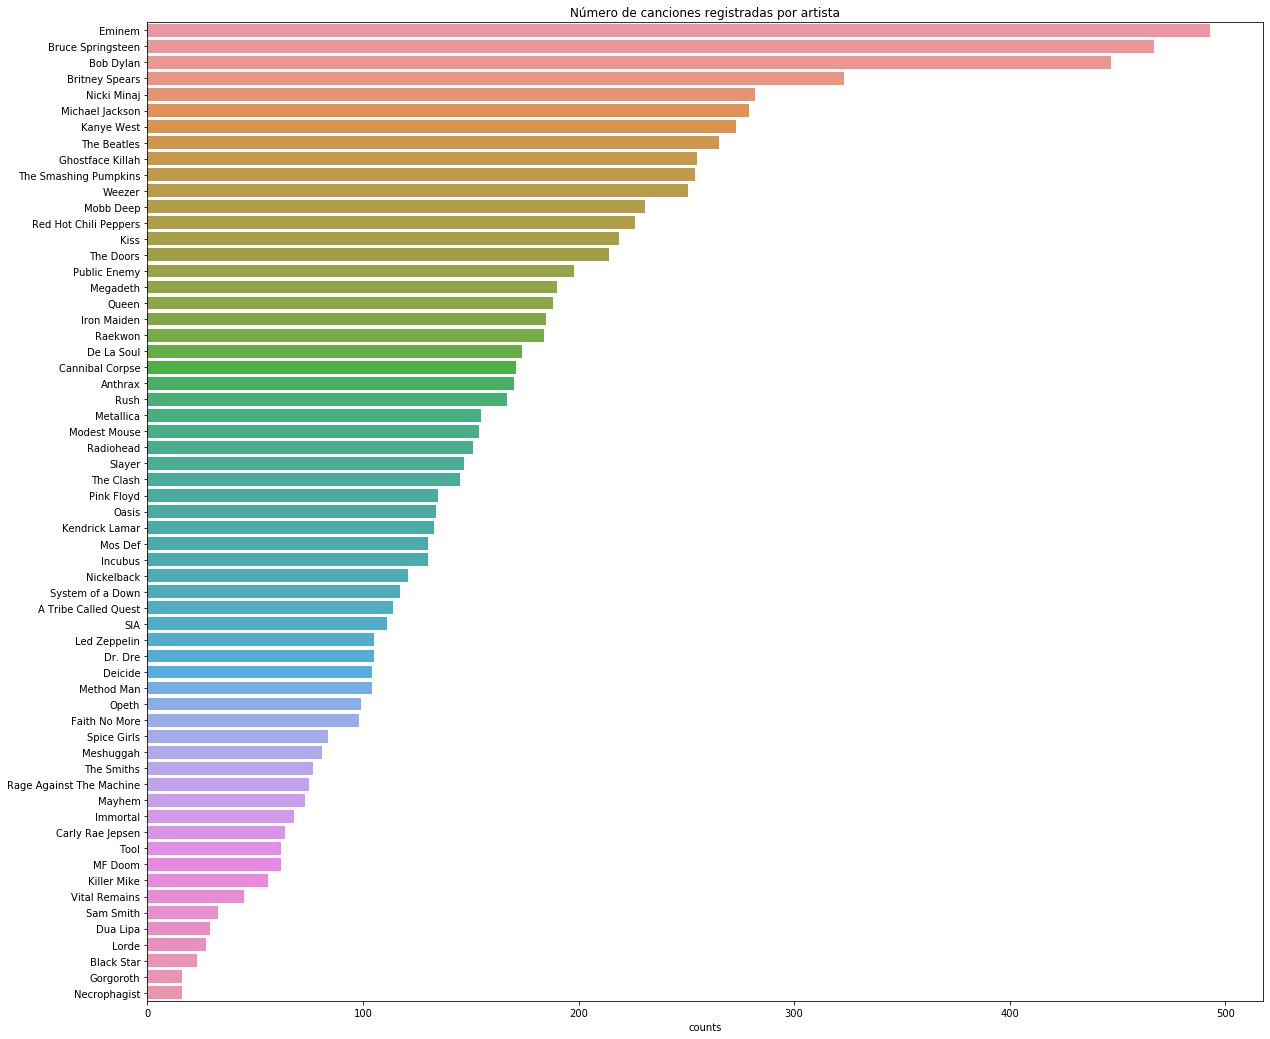

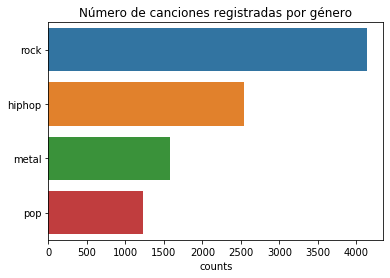

In [3]:
canciones = pd.DataFrame(data={"counts": df["artista"].value_counts()})
genero = pd.DataFrame(data={"counts": df["genero"].value_counts()})

plt.figure(figsize=(20,18))
barplot_art = sns.barplot( x="counts", y=canciones.index, data=canciones)
barplot_art.set_title('Número de canciones registradas por artista')

plt.figure()
barplot_gen = sns.barplot( x="counts", y=genero.index, data=genero)
barplot_gen.set_title('Número de canciones registradas por género')

A partir del gráfico se observa que el rock es el género con más canciones, seguido por el hiphop. En cuento artitas con más canciones el top 3 son: Eminen, Bruce Springsteen y Bob Dylan con más de 400 canciones.

## Matriz de ocurrencias

**Digresión**: Tokenización de Textos.

Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila representará una entrada (en este caso, una canción), y cada columna representará una palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra específica dentro de un conjunto de textos (corpus). El tokenizador más simple sklearn.feature_extraction.text.CountVectorizer genera una colección de textos a una matriz que representa la frecuencia dentro del texto de una palabra específica. El tokenizador funciona de la siguiente manera:

```python
from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
```

- Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn . Lea la documentación asociada a ésta. ¿Cuál es el objetivo de esta clase? 
    - **Respuesta**:
        - Los datos en forma de texto requieren una preparación especial antes de comenzar a usarlos en el modelamiento predictivo.
        - Se deben obtener las palabras que contiene el texto, este proceso se llama tokenización. Luego, las palabras deben ser codificadas como números para ser usados como entrada a los algoritmos de machine learning, esto es llamado extración de atributos o vectorización (feature extraction or vectorization).
        - CountVectorizer utilice el modelo de bag of words, donde a cada palabra se le asigna un único número. Entonces, cualquier documento, puede ser codificado como un vector de largo fijo con el largo del vocabulario de palabras conocidas. El valor en cada posición del vector puede ser llenado con la cuenta o frecuencia de cada palabra codificada.
        - CountVectorizer permite tokenizar y vectorizar una colección de documentos de texto y construir un diccionario de palabras conocidas, también puede codificar nuevos documentos usando ese diccionario. Para usar CountVectorizar se debe:
            - Crear una instancia de de la clase CountVectorizer.
            - Llamar a la función fit() para que la función aprenda el vocabulario de uno o más documentos.
            - Llamar a la función transform() sobre uno o más documentos para codificarlo como vector.
- Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos.
- Genere una función que replique el procedimiento para cada uno de los géneros.
- Comente sobre las principales características de cada género en cuanto a sus palabras.

In [4]:

# Genera un dataframe a partir de un vector y su vocabulario

def vector_a_df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Cancion{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

### Prueba con una sola canción

Para verificar el funcionamiento se realiza una prueba con una sóla canción

In [5]:
# Primero se realizar una prueba con una sola canción

texto = df["letra"].iloc[[1]]
display(texto)

vectorizer = CountVectorizer()
vectorizer.fit(texto)
vector = vectorizer.transform(texto)
tokens = vectorizer.get_feature_names()

voc_1can = pd.DataFrame(data=vectorizer.vocabulary_.values(),
                   index=vectorizer.vocabulary_.keys(),
                   columns=["palabras"])

vec_1can = vector_a_df(vector, tokens)


display(Markdown("**Vocabulario: número asignado a cada palabra**"))
display(voc_1can.sort_values(by="palabras").transpose())

display(Markdown("**Vector: repeticiones de palabras en el vector**"))
display(vec_1can)

1    Doomed to an after life of pain \n Seeing your...
Name: letra, dtype: object

**Vocabulario: número asignado a cada palabra**

,after,all,among,an,and,apparition,are,away,begins,bestow,...,time,to,unholy,up,upon,void,wanting,wish,you,your
palabras,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104


**Vector: repeticiones de palabras en el vector**

,after,all,among,an,and,apparition,are,away,begins,bestow,...,time,to,unholy,up,upon,void,wanting,wish,you,your
Cancion0,2,1,1,1,1,1,1,1,1,1,...,1,3,1,1,2,1,1,1,4,5


### 100 palabras más repetidas

None

Text(0.5, 1.0, '100 Palabras más frecuentes para todos los generos')

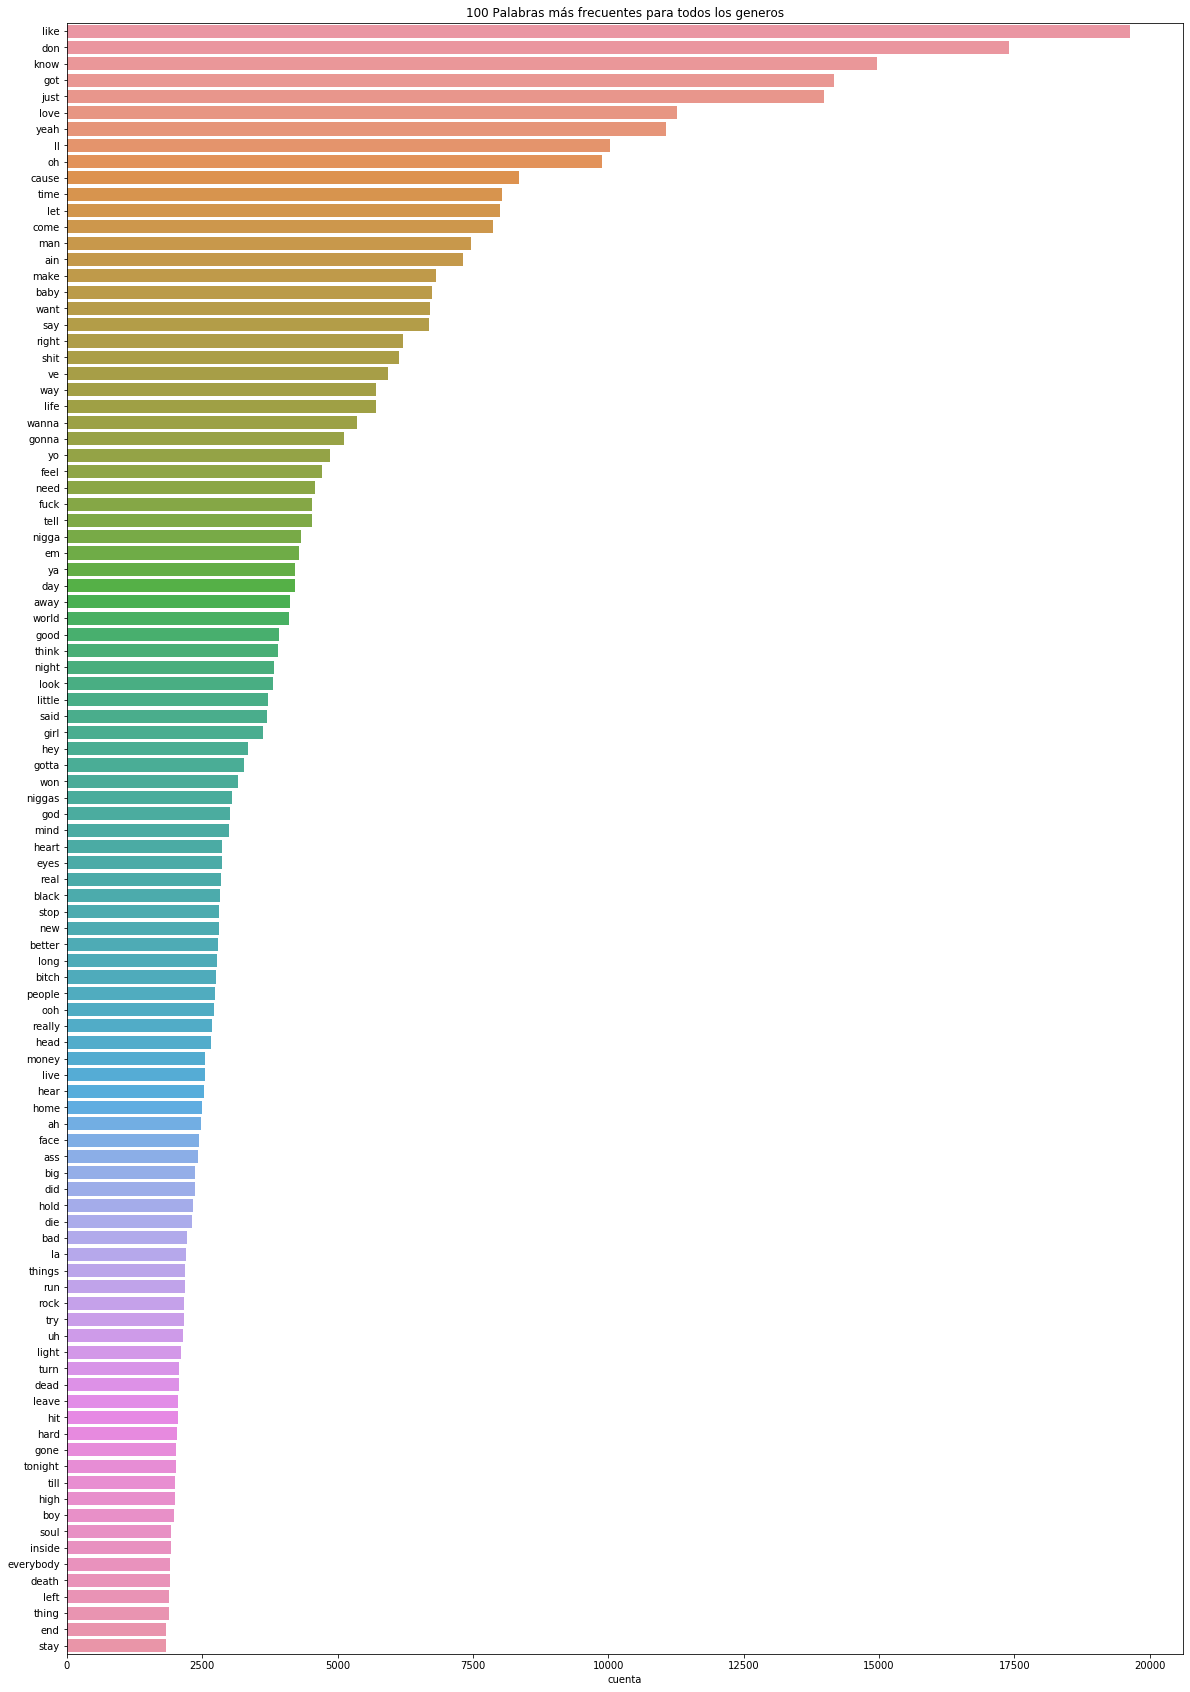

In [38]:
vectorizer = CountVectorizer(max_features=100, stop_words="english")
vectorizer.fit(df["letra"])
vector = vectorizer.transform(df["letra"])
tokens = vectorizer.get_feature_names()

voc_100 = pd.DataFrame(data=vectorizer.vocabulary_.values(),
                       index=vectorizer.vocabulary_.keys(),
                       columns=["palabras"])

df2_100 = vector_a_df(vector, tokens)

total_100 = df2_100.sum()

total_100 = pd.DataFrame(total_100, columns=["cuenta"])

display(total_100.sort_values(by="cuenta", ascending=False, inplace=True))

plt.figure(figsize=(20, 30))
barplot_gen = sns.barplot(x="cuenta",
                          y=total_100.index,
                          data=total_100
                          )
barplot_gen.set_title('100 Palabras más frecuentes para todos los generos')

### 100 palabras más repetidas por género

In [40]:
def get_vector(df, var, max_features=100):
    vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
    vectorizer.fit(df[var])
    vector = vectorizer.transform(df[var])
    tokens = vectorizer.get_feature_names()

    voc = pd.DataFrame(data=vectorizer.vocabulary_.values(),
                       index=vectorizer.vocabulary_.keys(),
                       columns=["palabras"])

    vec = vector_a_df(vector, tokens)

    total = vec.sum()

    return pd.DataFrame(total, columns=["cuenta"])


def get_vector_bygroup(df, var, grupo="genero"):
    
    vectores = []
    elementos = []
    for item in df[grupo].unique():
        df_temp = df[df[grupo] == item]
        vectores.append(get_vector(df_temp, var))
        elementos.append(item) 
    return elementos, vectores
        
generos, vectores =  get_vector_bygroup(df, "letra")

In [41]:
df_vectores = pd.concat(vectores, axis="columns",ignore_index=False)
df_vectores.columns = generos
df_vectores = df_vectores.fillna(0)
df_vectores["total"] = df_vectores.sum(axis="columns")
df_vectores.sort_values("total", ascending=False, inplace=True)
display(df_vectores)
display(df_vectores.sum(axis="index"))

,metal,rock,hiphop,pop,total
like,869.0,3710.0,12055.0,2995.0,19629.0
don,1181.0,5284.0,7604.0,3329.0,17398.0
know,1048.0,4702.0,6535.0,2677.0,14962.0
got,530.0,3872.0,7613.0,2156.0,14171.0
just,993.0,4103.0,6272.0,2610.0,13978.0
love,410.0,5114.0,2830.0,2914.0,11268.0
yeah,583.0,4157.0,4087.0,2244.0,11071.0
ll,1069.0,3825.0,3391.0,1743.0,10028.0
oh,509.0,4258.0,2375.0,2737.0,9879.0
cause,346.0,1750.0,4737.0,1523.0,8356.0


metal      44446.0
rock      141368.0
hiphop    205622.0
pop        78080.0
total     469516.0
dtype: float64

Al unir las 100 principales palabras para todos los géneros, se forma un con junto total de 184 palabras que es lo que muestra el dataframe

In [42]:
df_vectores_porc = df_vectores.copy()

for genero in generos:
    df_vectores_porc[genero] = df_vectores_porc[genero]/df_vectores_porc["total"]
    
for genero in generos:
    display(Markdown("**Palabras únicas al " + genero + "**"))
    display(df_vectores_porc[df_vectores_porc[genero] == 1][genero])

**Palabras únicas al metal**

death       1.0
blood       1.0
dead        1.0
hell        1.0
pain        1.0
kill        1.0
war         1.0
evil        1.0
fear        1.0
hate        1.0
free        1.0
lies        1.0
fight       1.0
flesh       1.0
cold        1.0
coming      1.0
dark        1.0
darkness    1.0
hands       1.0
truth       1.0
satan       1.0
earth       1.0
lives       1.0
fucking     1.0
lie         1.0
open        1.0
deep        1.0
killing     1.0
comes       1.0
human       1.0
burn        1.0
living      1.0
save        1.0
lord        1.0
Name: metal, dtype: float64

**Palabras únicas al rock**

yes      1.0
old      1.0
song     1.0
going    1.0
wrong    1.0
sky      1.0
roll     1.0
stand    1.0
town     1.0
round    1.0
days     1.0
Name: rock, dtype: float64

**Palabras únicas al hiphop**

ass       1.0
niggaz    1.0
hit       1.0
rap       1.0
fuckin    1.0
wit       1.0
game      1.0
gon       1.0
word      1.0
son       1.0
damn      1.0
check     1.0
beat      1.0
eminem    1.0
huh       1.0
talk      1.0
verse     1.0
chorus    1.0
bout      1.0
Name: hiphop, dtype: float64

**Palabras únicas al pop**

nicki      1.0
girls      1.0
bitches    1.0
na         1.0
thought    1.0
break      1.0
da         1.0
hot        1.0
care       1.0
crazy      1.0
eh         1.0
chick      1.0
Name: pop, dtype: float64

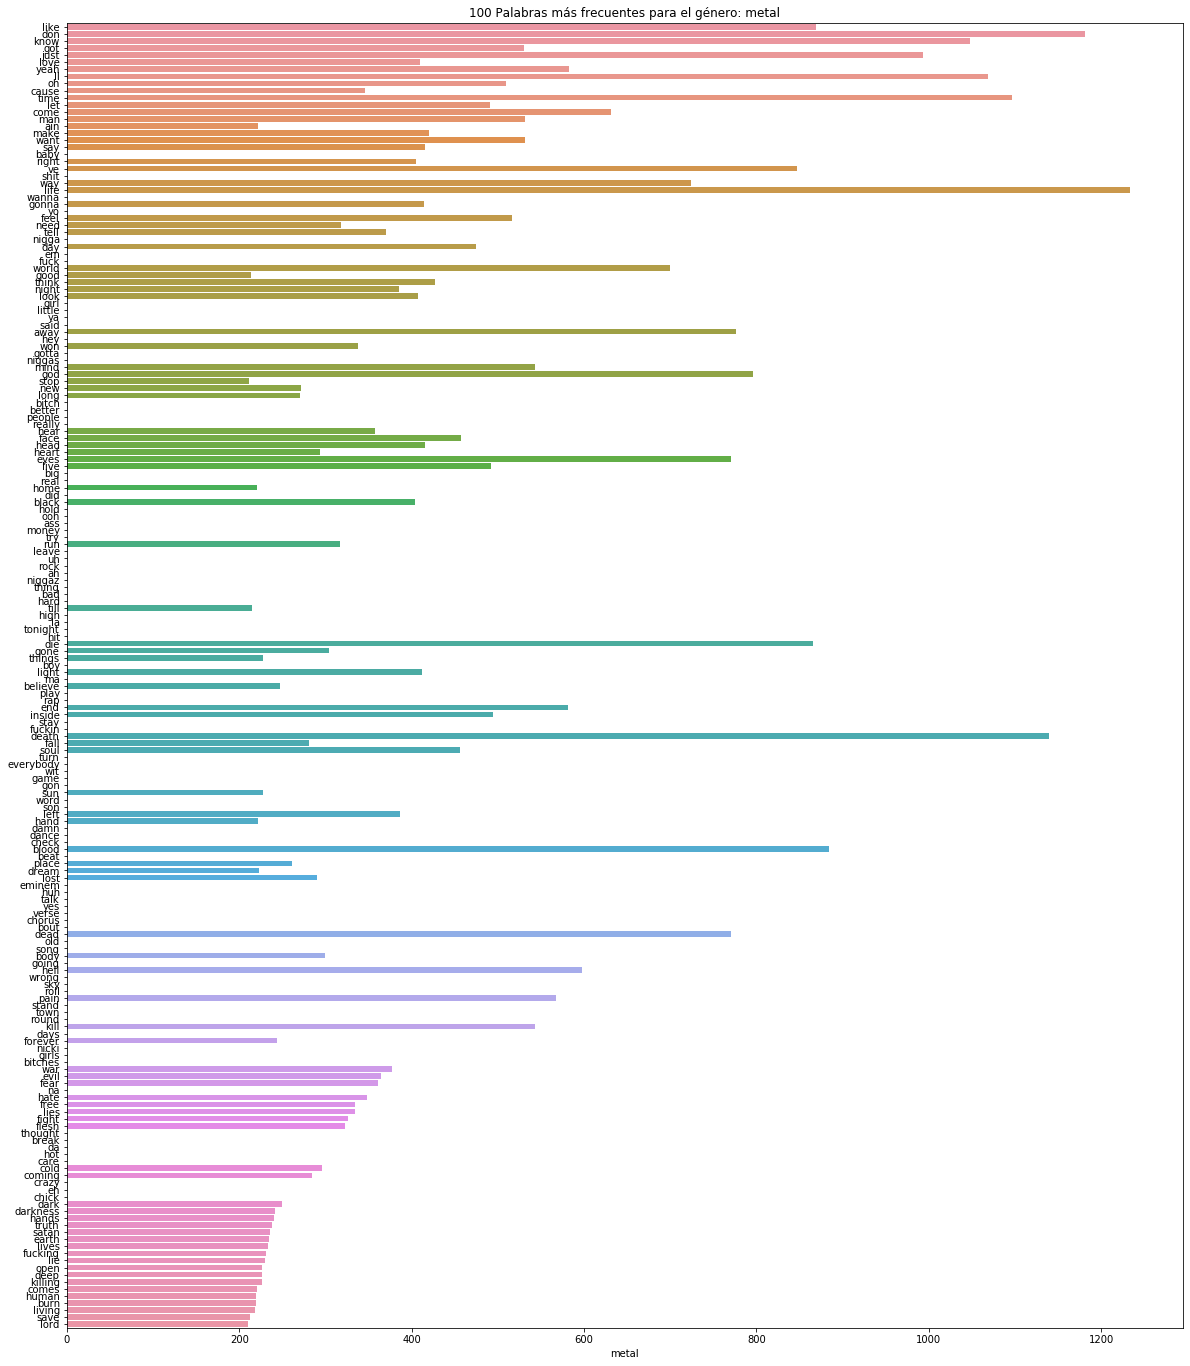

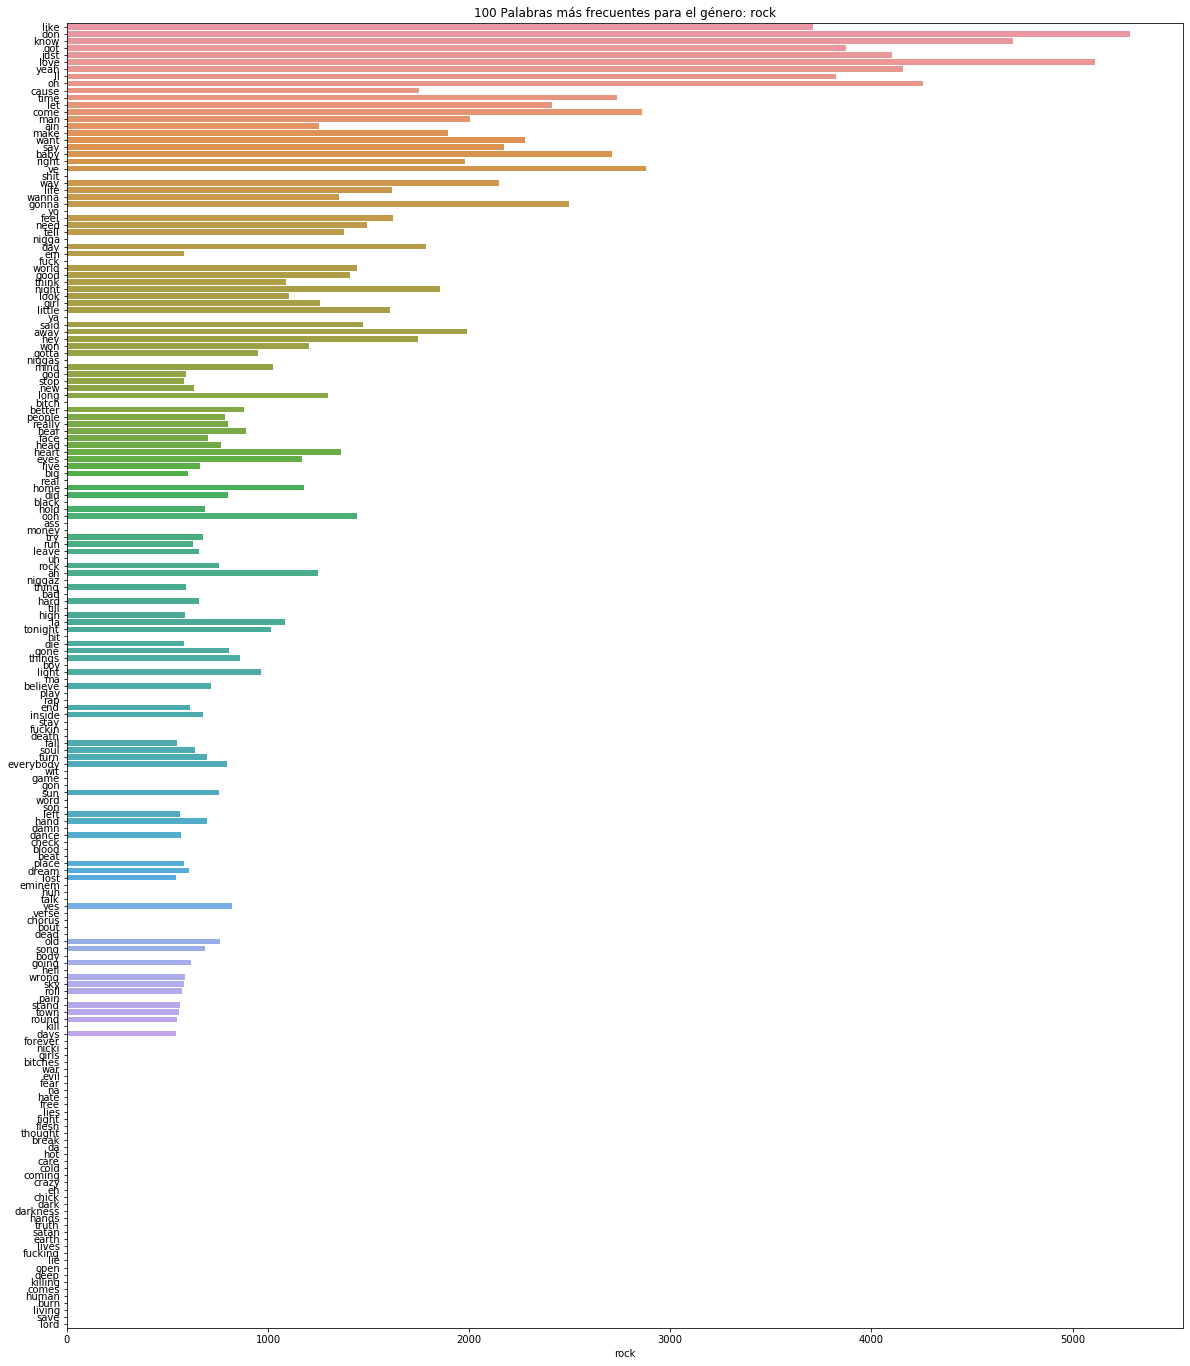

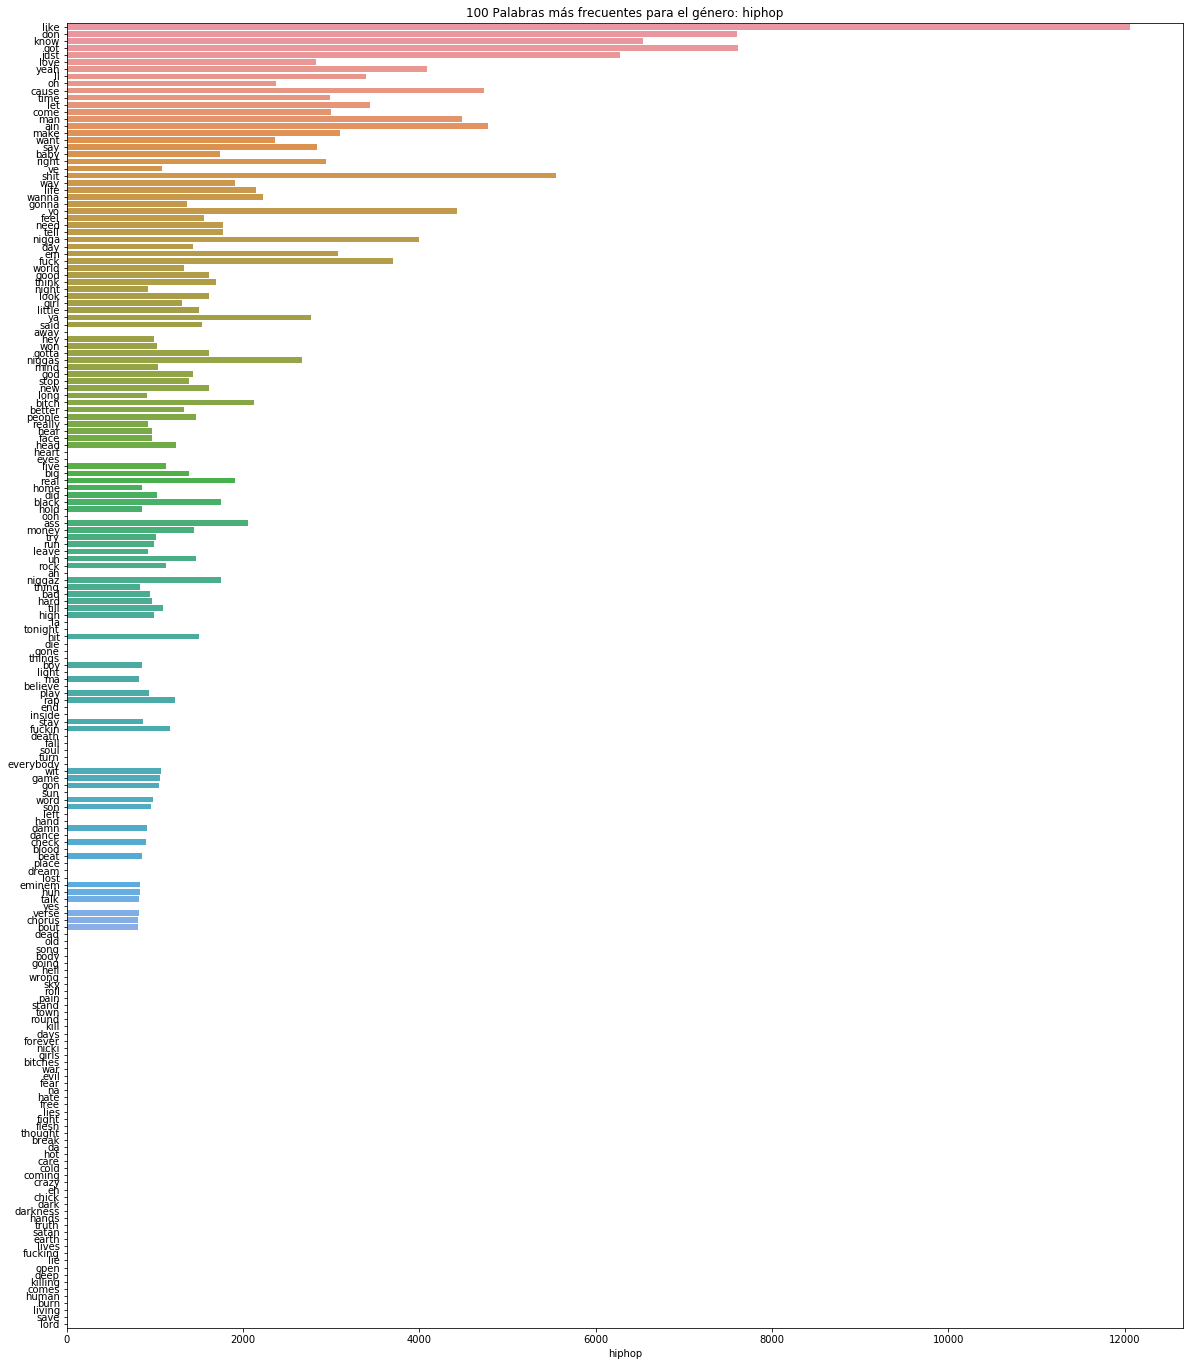

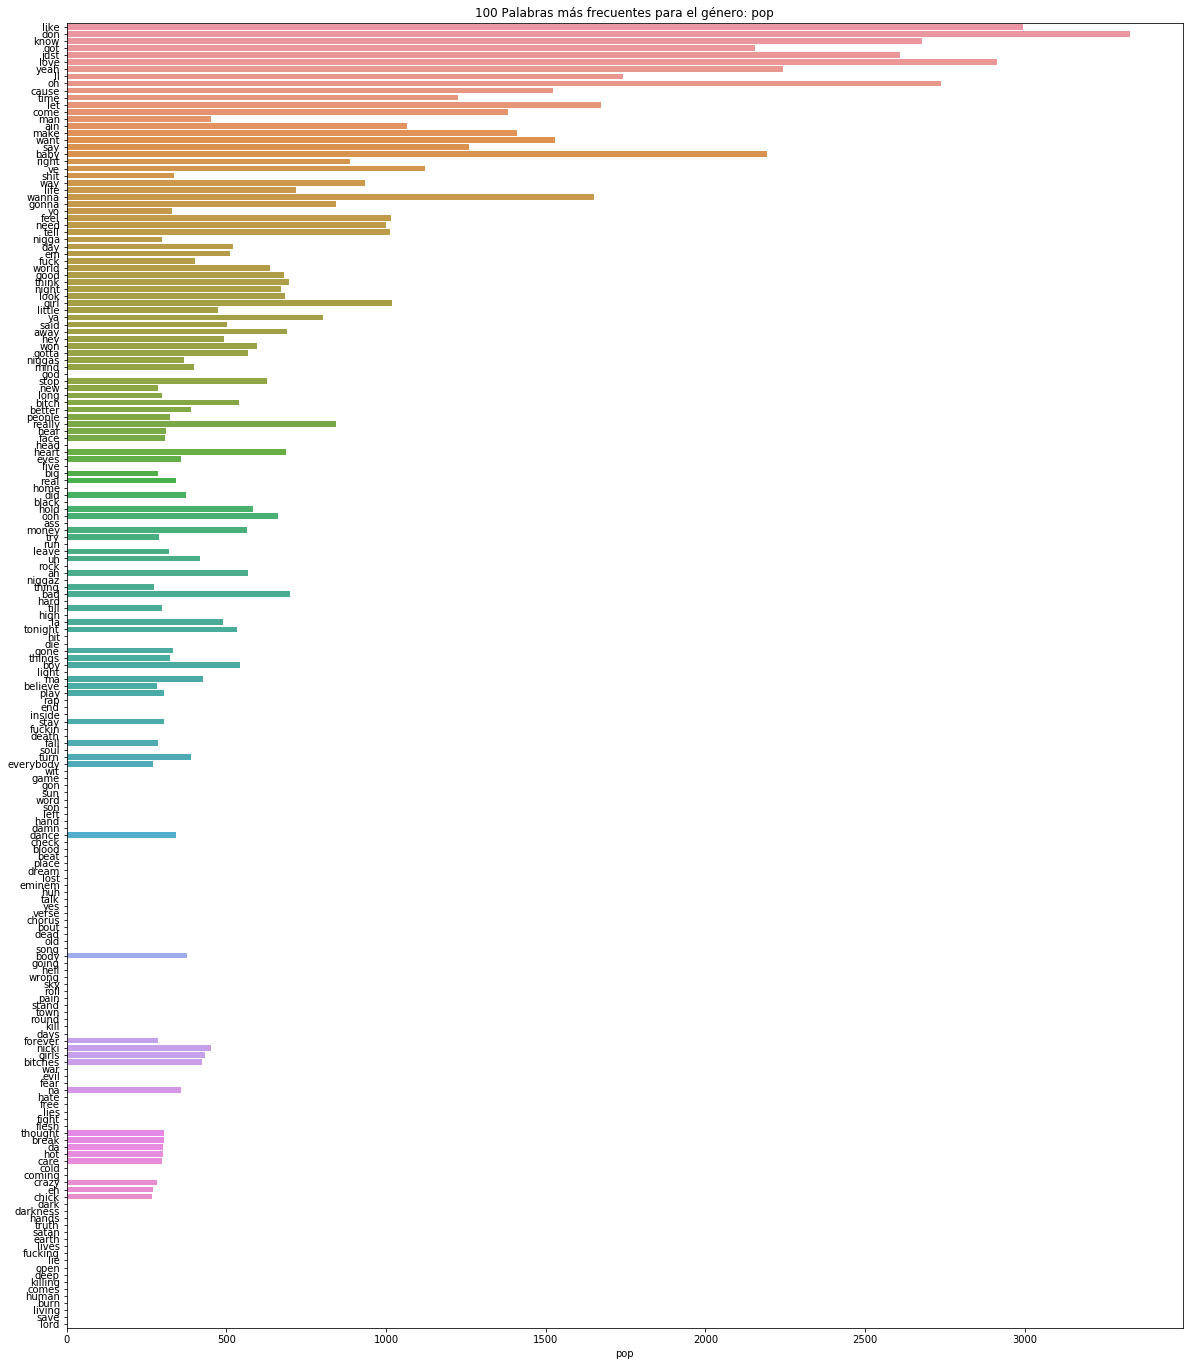

In [43]:
# Grafica 100 palabras más frecuentes por género

for i, genero in enumerate(generos):
    plt.figure(figsize=(20, 24))
    barplot_gen = sns.barplot(
        x=genero,
        y=df_vectores.index,
        data=df_vectores)
    barplot_gen.set_title(
        '100 Palabras más frecuentes para el género: ' + genero)

### Comentarios

- Al aplicar la opción stop_words permite eliminar las palabras que sólo conectn frases (cómo artículos, etc) que permiten catalogar ya que se repiten mucho entre cada género y que no hubieran sido útiles.
- Es interesante visualizar la lista de palabras que son únicas de cada género, las que podrían ser muy útiles para clasificar las letras por género. Aunque por su número

## Entrenamiento del Modelo

Digresión: sklearn Pipelines

La clase Pipeline del módulo sklearn.pipeline permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikit-learn. En sí, la clase cuenta con los métodos clásicos fit, predict y score y presenta un comportamiento idéntico a los demás objetos de scikit-learn. Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo.

Componentes de un Pipeline

Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo Estandarlizarlo, posteriormente extraer sus principales componentes y finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:

```python
pipeline_model = Pipeline([('scale', StandardScaler()),
    ('pca', RandomizedPCA(n_components=3)),
    ('model', LinearRegression())])
```

Algunos de los elementos a considerar:

1. Cada paso se considera como una tupla, donde se declara el nombre del paso y la función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que asociamos el método StandardScaler con el string scale.
2. Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso representa el orden de ejecución.

Posteriormente el objeto creado puede utilizarse con los siguientes métodos:

```python
pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(y_test)
```

- Importe MultinomialNB, train_test_split, Pipeline, confusion_matrix y classification_report.
- Genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria.
- Monte el modelo dentro de un Pipeline , donde el primer paso es implementar CountVectorizer y el segundo sea ejecutar el clasificador MultinomialNB.
- A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones
correspondientes?

```python
['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking
light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for
two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move
bitch, get out the way Get out the way bitch, get out the way', # Ludacris -
Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and
behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm
the one who had to learn to \
build a heart made of armor From the girl who made you soup and tied your
shoes when you were hurting\
You are not deserving, you are not deserving" #Banks -
Drowing
]
```
- Genere una predicción implementando la muestra de validación y contraste las predicciones del modelo con las etiquetas verdaderas. Reporte las principales métricas.

In [91]:
# Encoding

df_encod = df.copy()
labelencoder = LabelEncoder()

df_encod["genero"] = labelencoder.fit_transform(df_encod["genero"])

display(df_encod.head())

,artista,genero,cancion,letra
0,Vital Remains,1,Human Sacrifice,Taken to death from sacrifice \n Carving out y...
1,Vital Remains,1,Ressurrected,Doomed to an after life of pain \n Seeing your...
2,Vital Remains,1,Fallen Angels,Fallen angels souls of hate \n Fallen angels c...
3,Vital Remains,1,Excruciating Pain,Feel the torment of brutal bestial torture \n ...
4,Vital Remains,1,Nocturnal Blasphemy,Blasphemy \n Awakened by nocturnal cries \n Su...


In [94]:
def vector_a_df2(wm, feat_names):

    # create an index for each row
    #doc_names = ['Cancion{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), columns=feat_names)
    return(df)

In [97]:
vectorizer = CountVectorizer(max_features=100, stop_words="english")
vectorizer.fit(df_encod["letra"])
vector = vectorizer.transform(df_encod["letra"])
tokens = vectorizer.get_feature_names()


df_vector = vector_a_df2(vector, tokens)

df_encod2 = df_vector.copy()
df_encod2["genero"] = df_encod["genero"]
display(df_encod2)

,ah,ain,ass,away,baby,bad,better,big,bitch,black,...,ve,wanna,want,way,won,world,ya,yeah,yo,genero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


Nota: el vector objetivo sólo se codifica, no se binariza (separa en columnas), idea tomada del ejemplo https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [99]:
var_atributos = [x for x in df_encod2.columns if x != 'genero']
var_objetivo = [x for x in df_encod2.columns if x == 'genero']

X_train, X_test, y_train, y_test = train_test_split(
    df_encod2.loc[:, var_atributos],
    df_encod2.loc[:, var_objetivo],
    test_size=.4,
    random_state=4545
)

In [102]:
# Se aplico CountVectorizer fuera del pipeline, ya que generaba problemas.
# en este link https://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
# usan CountVectorizer con pipeline,

pipeline_modelo = Pipeline([
#    ("cv", CountVectorizer(max_features=100, stop_words="english", lowercase=False)),
    ("clasificar", MultinomialNB()),
])

pipeline_modelo.fit(X_train,y_train)
y_hat = pipeline_modelo.predict(X_test)

In [103]:
display(y_hat)

array([3, 3, 1, ..., 0, 1, 3])

## Mejora del Modelo

- Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
- Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
- Comente sobre el desempeño general de éste.